# Qubit Reuse Compilation

This notebook contains an overview of how to use the qubit reuse compilation as a hypertket pass. This capability applies a compilation strategy for reducing the number of qubits in a quantum circuit as detailed in [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057) by Matthew DeCross, Eli Chertkov, Megan Kohagen and Michael Foss-Feig.

If you wish to cite this capability in any academic publications, we recommend citing our paper [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057).

## Setup Nexus Project

Nexus enables access to H-Series. An existing project is activated, **Qubit-Reuse-Demonstration**.

In [1]:
import qnexus
import uuid

project = qnexus.projects.get_or_create(name="Qubit-Reuse-Demonstration")
qnexus.context.set_active_project(project)
job_name_suffix = uuid.uuid1()

The `QuantinuumConfig` is instantiated below to `backend_config` the `H2-Emulator`, an emulator instance of *System Model H2*, that is hosted on nexus.

In [2]:
qntm_config = qnexus.QuantinuumConfig(device_name="H2-Emulator")

## Simple Example

Most current techniques for circuit optimisation focus on reducing the number of gates in a circuit, often aiming to reduce the number of multi-qubit gates as they are known to be more error-prone. The prevailing logic is that a shorter circuit accumulates less noise and so provides better results. The compilation technique available in this repository instead focuses on reducing the number of qubits, or width, of a circuit. This can help turn a circuit that at first seems infeasible on small near-term devices into one that can be executed. A full explanation of the techniques available can be read in the paper [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057).

Let's first consider how such a technique is possible via a basic example. An existing circuit is constructed and uploaded to nexus.

In [3]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = (
    Circuit(3, 3)
    .H(0)
    .CX(0, 1)
    .CX(1, 2)
    .Measure(0, 0)
    .Measure(1, 1)
    .Measure(2, 2)
)

render_circuit_jupyter(circuit)

In [4]:
ref_circuit = qnexus.circuits.upload(circuit, name="simple-circuit")

### Compilation with Nexus

The circuit above is compiled remotely with nexus. The `optimisation_level` is set to `0` and the compiled circuit only satisfies the gate-set predicate for the nexus-hosted H1 emulator.

In [5]:
ref_compile_job = qnexus.start_compile_job(
    circuits=[ref_circuit],
    name=f"compile-simple-circuit-{job_name_suffix}",
    backend_config=qntm_config,
    optimisation_level=0
)

c:\Users\Irfan.Khan\Projects\nexus-docs\.venv\Lib\site-packages\qnexus\client\utils.py:170: DeprecationWarning: The `circuits` argument is deprecated and will be removed in a future version. Please use `programs`.
  warnings.warn(


In [6]:
qnexus.jobs.wait_for(ref_compile_job)

JobStatus(status=<JobStatusEnum.COMPLETED: 'COMPLETED'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 11, 3, 13, 15, 31, 315319, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 11, 3, 13, 15, 12, 318793, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 11, 3, 13, 15, 12, 198667, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 11, 3, 13, 15, 27, 904089, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None, cost=None)

In [7]:
job_result = qnexus.jobs.results(ref_compile_job)[0]

In [8]:
compilation_result_ref = job_result.get_output()

In [9]:
compiled_circuit = compilation_result_ref.download_circuit()

In [10]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(compiled_circuit)

However, looking at the Circuit we can see that the `CX` gate targeting `q[2]` is executed after all the operations on `q[0]`. As an alternative Circuit, we could measure `q[0]`, reset it to the `0` state and then replace the `CX` gate originally between `q[1]` and `q[2]` with between `q[1]` and `q[0]`. A circuit is constructed with these modified instructions and uploaded to nexus.

In [11]:
from pytket import OpType

circuit = (
    Circuit(2, 3)
    .H(0)
    .CX(0, 1)
    .Measure(0, 0)
    .add_gate(OpType.Reset, [0])
    .CX(1, 0)
    .Measure(1, 1)
    .Measure(0, 2)
)
render_circuit_jupyter(circuit)

In [12]:
ref_circuit_2 = qnexus.circuits.upload(circuit, name="simple-circuit-2")

In [13]:
compile_job_ref = qnexus.start_compile_job(
    circuits=[ref_circuit_2], 
    name=f"compile-job-simple-circuit-2-{job_name_suffix}", 
    backend_config=qntm_config, 
    optimisation_level=0
)

In [14]:
qnexus.jobs.wait_for(compile_job_ref)
compile_result = qnexus.jobs.results(compile_job_ref)[0]
compile_ref_circuit = compile_result.get_output()

In this case, by reusing `q[0]` we've completed the same circuit using one fewer qubit.

This repository provides a `pytket` compiler pass for automatically applying qubit reuse schemes to `pytket` Circuit objects. If you are unfamiliar with compilation in `pytket` the [compilation example notebook](https://github.com/CQCL/pytket/blob/main/examples/compilation_example.ipynb) in the `pytket` repository covers the basics.

Lets construct a `QubitReuseConfig` instance and apply it to our original 3-qubit circuit.

One of the arguments for qubit reuse compilation is the ordering method. The reuse compilation works by finding causal cones of qubit outputs (See Fig. 2 in [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057)) and implementing all of the gates in a given causal cone before proceeding to other causal cones. The order in which causal cones are chosen for implementation determines how many qubits are required in the output circuit, since causal cones that share many qubits generally require adding fewer new live qubits to a circuit to implement. An optimal ordering of causal cones produces a circuit with a minimum number of qubits.

For now we will look at the `BruteForceOrderConfig` option.

In [15]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = (
    Circuit(3, 3)
    .H(0).CX(0, 1)
    .CX(1, 2)
    .Measure(0, 0)
    .Measure(1, 1)
    .Measure(2, 2)
)

ref_circ = qnexus.circuits.upload(circuit=circuit, name=f"circuit-0-{job_name_suffix}")

render_circuit_jupyter(circuit)

In [ ]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig,
    QubitReuseConfig,
    BruteForceOrderConfig
)

qubit_reuse_config = QubitReuseConfig(
    ordering_config=BruteForceOrderConfig(),
    enable_qubit_reuse=True,
    dual_circuit_strategy=None
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=qubit_reuse_config
)

In [17]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circ],
    name=f"compile-job-0-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [18]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()

compile_circuit_ref

CircuitRef(id=UUID('c7891ceb-defe-476e-a539-38887f0e936c'), annotations=Annotations(name='circuit-0-20c3b29c-b8b7-11f0-8dff-28d0eaef1b44-EmulatorEnabledQuantinuumBackend-final', description=None, properties=OrderedDict(), created=datetime.datetime(2025, 11, 3, 13, 15, 55, 580068, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2025, 11, 3, 13, 15, 55, 591667, tzinfo=TzInfo(UTC))), project=ProjectRef(id=UUID('1d9300b7-775e-463f-8126-90aafe4b30b4'), annotations=Annotations(name='Qubit-Reuse-Demonstration', description='Circuits and Results for Qubit Reuse Compilation Demonstration', properties=OrderedDict(), created=datetime.datetime(2024, 7, 15, 10, 48, 7, 635959, tzinfo=TzInfo(UTC)), modified=datetime.datetime(2024, 7, 15, 10, 48, 7, 635959, tzinfo=TzInfo(UTC))), contents_modified=datetime.datetime(2025, 11, 3, 13, 15, 55, 667889, tzinfo=TzInfo(UTC)), archived=False, type='ProjectRef'), type='CircuitRef')

In [19]:
c = compile_circuit_ref.download_circuit()
render_circuit_jupyter(c)

## Demonstrating Compilation with Qubit Reuse for QAOA Circuits

Combinatorial optimization problems in quantum computing can be considered as the problem of finding the ground state and its energy for a diagonal Hamiltonian on $n$ qubits:

$H = \sum\limits_{x\in\{0,1\}^{n}}C(x)|x\rangle\langle x|$ 

The paper [A Quantum Approximate Optimisation Algorithim](https://arxiv.org/abs/1411.4028) by Edward Farhi, Jeffrey Goldstone and Sam Gutmann details an algorithm for doing this.

A commonly tackled combinatorial optimization problem is the Max Cut problem: given some graph with $N$ nodes and $E$ edges, split the nodes into two subsets such that there is a maximum number of edges between both subsets. This is equivalent to finding the ground state and its energy for the following Hamiltonian: 

$H = -\sum\limits_{(j,k)\in E} 0.5(1 - Z_jZ_k)$ 

Since the first term in parentheses shifts the energy by an overall constant, it can be ignored.

Let's create a graph and consider an example problem using `networkx`.

**Note:** To run this example, run `pip install networkx matplotlib` in your python environment.

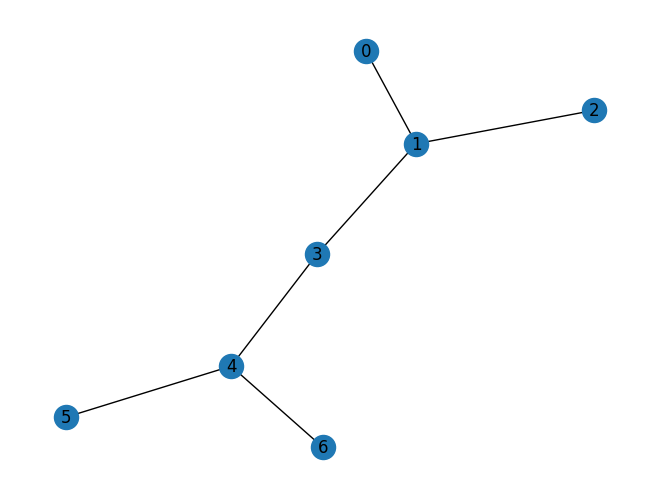

In [20]:
import networkx as nx

max_cut_graph_edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6)]
max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

For this problem, having nodes `1` and `4` in the same subset (i.e. labelled differently to the remaining nodes) gives 6 edges between subsets, the maximum result.

[A Quantum Approximate Optimisation Algorithim](https://arxiv.org/abs/1411.4028) uses a variational algorithim with a parameterised circuit construction to find the maximum eigenvalue and corresponding eigenstates of the encoded Hamiltonian. From here on we will not look at how to solve the problem, but instead take the circuit construction proposed and show how qubit reuse can reduce the number of qubits in the circuit. 

To do so, we will define a function to convert the edges of a graph to a `pytket` QAOA `Circuit`. Technically, qubit reuse could depend on the order in which we insert gates corresponding to edges, but we will not worry about that for this demonstration.

In [21]:
from typing import List, Tuple

def gen_qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                             n_nodes: int,
                             mixer_angles: List[float],
                             cost_angles: List[float],) -> Circuit:
    """ Generate QAOA MaxCut circuit. """
    assert len(mixer_angles) == len(cost_angles)

    # initial state
    qaoa_circuit = Circuit(n_nodes)
    for qubit in range(n_nodes):
        qaoa_circuit.H(qubit)

    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):

        for edge in edges:
            qaoa_circuit.ZZPhase(cost, edge[0], edge[1])

        for i in range(n_nodes):
            qaoa_circuit.Rx(mixer,i)

    qaoa_circuit.measure_all()
    return qaoa_circuit

The `mixer_angles` and `cost_angles` inputs are the parameterised values used to explore the solution space and find the maximum eigenvalue and corresponding eigenstates. For this example, which is only considering qubit reuse, we will set them arbitrarily to values that won't be optimised away.

In [22]:
qaoa_circuit = gen_qaoa_max_cut_circuit(max_cut_graph_edges, 7, [0.3], [0.3])
ref_circuit = qnexus.circuits.upload(circuit=qaoa_circuit, name=f"qaoa-circuit-{job_name_suffix}")
render_circuit_jupyter(qaoa_circuit)

We've constructed a 7-qubit circuit: an intuitive explanation of the circuit constructed may be that each edge in the graph corresponds to a ZZ term in the Hamiltonian, and each ZZ term in the Hamiltonian corresponds to a ZZPhase gate in the circuit.

Can qubit reuse reduce this? 

Here the `BruteForceOrder` `OrderingMethod` is used. This will take a long time to run since it will calculate and score every possible ordering for merging causal cones, with the number of orders scaling exponentially.

In [23]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    BruteForceOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=BruteForceOrderConfig(),
        dual_circuit_strategy=DualStrat.AUTO
    )
)

In [24]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-1-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [25]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 2 qubits.


By applying the qubit reuse pass we're able to reduce the number of qubits in the Circuit from 7 to 2. 

Lets consider a larger, random problem.

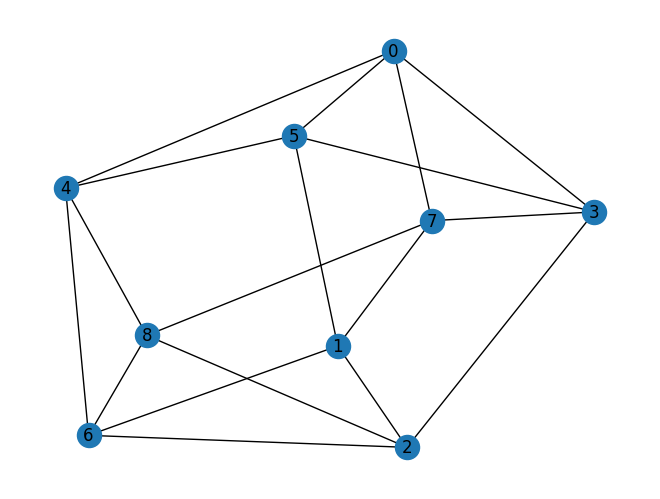

In [26]:
random_9_node_graph = nx.random_regular_graph(4, 9)
nx.draw(
    random_9_node_graph, 
    labels={
        node: node 
        for node in random_9_node_graph.nodes()
    }
)

In [27]:
random_9_node_graph_edges = list(random_9_node_graph.edges())
qaoa_circuit_9 = gen_qaoa_max_cut_circuit(random_9_node_graph_edges, 9, [0.3], [0.3])
ref_circuit = qnexus.circuits.upload(circuit=qaoa_circuit_9, name="qaoa-9")
render_circuit_jupyter(qaoa_circuit_9)

In [28]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-2-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [29]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 6 qubits.


In [30]:
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 6 qubits.


Given this, the qubit reuse package comes with several other `OrderingMethod` functions for finding solutions for larger problems. Lets see how each of them perform for a much larger problem.

## Additional Ordering Methods

Note that all the functions provided below correspond to the techniques outlined in [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057).

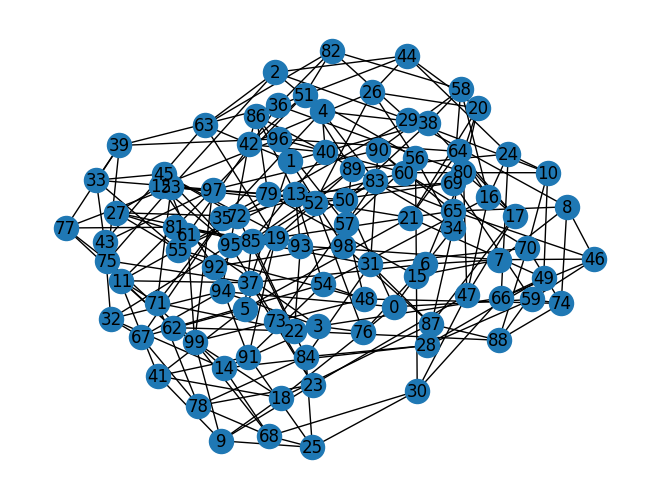

In [31]:
random_100_node_graph = nx.random_regular_graph(5, 100)
nx.draw(
    random_100_node_graph, labels={node: node for node in random_100_node_graph.nodes()}
)

In [32]:
random_100_node_graph_edges = list(random_100_node_graph.edges())
qaoa_circuit_100 = gen_qaoa_max_cut_circuit(
    random_100_node_graph_edges, 100, [0.3], [0.3]
)
ref_circuit = qnexus.circuits.upload(circuit=qaoa_circuit_100, name="qaoa-100")

Using `OrderingMethod.LocalGreedyOrder()`.

In [33]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    LocalGreedyOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=LocalGreedyOrderConfig(),
        dual_circuit_strategy=DualStrat.AUTO
    )
)

In [34]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-3-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [35]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 49 qubits.


Using `OrderingMethod.LocalGreedyFirstNodeSearchOrder()`.

In [36]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    LocalGreedyFirstNodeSearchOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=LocalGreedyFirstNodeSearchOrderConfig(),
        dual_circuit_strategy=DualStrat.AUTO
    )
)

In [37]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-4-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [38]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 49 qubits.


The default settings for qubit reuse will use `OrderingMethod.ConstrainedOptOrder()` for qubit numbers between 10 and 25. The `ConstrainedOptOrder` function corresponds to the CP-SAT method outlined in the paper, which finds the optimal reduced number of qubits. The complexity of CP-SAT is highly dependent on circuit structure, so it may or may not take a long time for larger circuits.

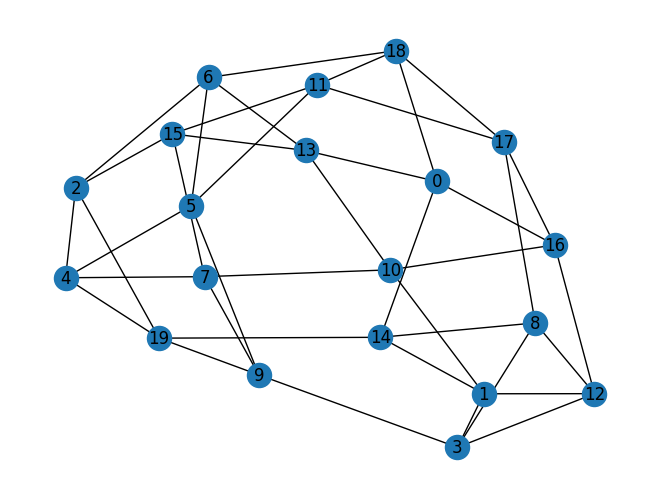

In [39]:
random_20_node_graph = nx.random_regular_graph(4, 20)
nx.draw(
    random_20_node_graph, labels={node: node for node in random_20_node_graph.nodes()}
)

In [40]:
random_20_node_graph_edges = list(random_20_node_graph.edges())
qaoa_circuit_20 = gen_qaoa_max_cut_circuit(random_20_node_graph_edges, 20, [0.3], [0.3])
ref_circuit = qnexus.circuits.upload(circuit=qaoa_circuit_20, name="qaoa-20")
render_circuit_jupyter(qaoa_circuit_20)

In [41]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    ConstrainedOptOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=ConstrainedOptOrderConfig(),
        dual_circuit_strategy=DualStrat.DUAL
    )
)

In [42]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-5-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [43]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 11 qubits.


`OrderingMethod.DefaultOrder()` switches between the four ordering methods shown depending on the number of qubits.

In [44]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    DefaultOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=DefaultOrderConfig(),
        dual_circuit_strategy=DualStrat.DUAL
    )
)

In [45]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-6-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [46]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 11 qubits.


The qubit reuse compilation pass has two further parameters that can be used. 

The first is `DualStrat`. Given that some of the available reodering methods are heuristics, sometimes a better solution can be found by running the algorithm on the dual circuit as described in [Qubit-reuse compilation with mid-circuit measurement and reset](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041057). In this case, we can run the qubit reuse scheme on the reverse (dual) circuit and then reverse it again to get a logically equivalent circuit. 

`DualStrat` has three options: `Single`, `Dual` and `Auto`. `Single` runs the qubit reuse algorithm on the given circuit only. `Dual` runs the qubit reuse algorithm on the reversed circuit and `Auto` runs on both the given and reversed circuit and returns the circuit with fewer qubits. If both circuits have the same number of qubits it returns the circuit with better depth, defaulting to the `None` strategy if both are deemed equivalent.  By default, and for best performance, `Auto` is used. 

We will look at how to run it using the previous QAOA examples.

In [47]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    DefaultOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=DefaultOrderConfig(),
        dual_circuit_strategy=DualStrat.DUAL
    )
)

In [48]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-7-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [49]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 11 qubits.


We can also set a minimum number of qubits as a target for the qubit reuse algorithm, which guarantees that the returned circuit whose number of qubits is equals to or less than the setting qubit number.

We can take the QAOA problem we have just run and specify a minimum number of qubits larger than the 11 it returned.

In [53]:
from quantinuum_schemas.models.hypertket_config import (
    HyperTketConfig, 
    QubitReuseConfig,
    DefaultOrderConfig,
    DualStrat
)

hypertket_config = HyperTketConfig(
    qubit_reuse_config=QubitReuseConfig(
        enable_qubit_reuse=True,
        ordering_config=DefaultOrderConfig(),
        dual_circuit_strategy=DualStrat.DUAL,
        min_qubits=14
    )
)

In [54]:
compile_job = qnexus.start_compile_job(
    programs=[ref_circuit],
    name=f"compile-job-8-{job_name_suffix}",
    hypertket_config=hypertket_config,
    backend_config=qntm_config,
    optimisation_level=0
)

In [55]:
qnexus.jobs.wait_for(compile_job)
compile_circuit_ref = qnexus.jobs.results(compile_job)[0].get_output()
cc = compile_circuit_ref.download_circuit()
print("Reused Circuit has", cc.n_qubits, "qubits.")

Reused Circuit has 14 qubits.


We can see that by specifying a minimum of 11 qubits, the returned circuit is now larger. 